In [ ]:
import pandas as pd
import numpy as np # linear algebra
import keras 
import gc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout
import tensorflow as tf
import sklearn
from sklearn import *
import heapq
import scipy as sp
from sklearn.utils import check_random_state
from abc import ABCMeta, abstractmethod
from functools import partial
import collections

# Read Data

In [ ]:
def read_data(dataset_name):
  if dataset_name is 'breast_cancer':
    data = datasets.load_breast_cancer()
    feature_names = data .feature_names
    target_names = data .target_names
    (train,test,labels_train,labels_test) = model_selection.train_test_split(data.data, data.target, train_size=0.80)
    return data,data.target,feature_names,target_names,train,labels_train,test,labels_test
  elif dataset_name is 'hepatisis':
    hepatisis = pd.read_csv('hepatisis.csv')
    hepatisis.drop(['protime'],axis=1, inplace=True)
    categorical=pd.DataFrame(hepatisis.select_dtypes(exclude='number')).columns
    number=pd.DataFrame(hepatisis.select_dtypes(include='number')).columns
    hepatisis.dropna(subset=categorical,inplace=True)
    imp=sklearn.impute.SimpleImputer(strategy='mean')
    numbers_cols=pd.DataFrame(hepatisis.loc[:,number], columns=number)
    imp.fit(numbers_cols)
    numbers_cols=imp.transform(numbers_cols)
    hepatisis.drop(number,axis=1,inplace=True)
    hepatisis.reset_index(drop=True,inplace=True)
    numbers_data=pd.DataFrame(numbers_cols,columns=number)
    hepatisis_main=pd.concat([hepatisis,numbers_data], axis=1)
    data=hepatisis_main.drop(['class'],axis=1)
    targets=hepatisis_main['class']
    le= sklearn.preprocessing.LabelEncoder()
    le.fit(targets)
    labels = le.transform(targets)
    class_names = le.classes_
    categorical_features=range(13)                   
    categorical_names = {}
    for feature in categorical_features:
        le = sklearn.preprocessing.LabelEncoder()
        le.fit(data[categorical[feature]])
        data[categorical[feature]] = le.transform(data[categorical[feature]])
        categorical_names[feature] = le.classes_
        
    data = data.astype(float)
    train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels, train_size=0.80)
    return data,labels,class_names,categorical_features,categorical_names,categorical,train,labels_train,test,labels_test
  elif dataset_name is 'liver':
      liver= pd.read_csv('IndianLiverPatientDataset(ILPD).csv')
      categorical=pd.DataFrame(liver.select_dtypes(exclude='number')).columns
      number=pd.DataFrame(liver.select_dtypes(include='number')).columns
      liver.dropna(subset=categorical,inplace=True)
      imp=sklearn.impute.SimpleImputer(strategy='mean')
      numbers_cols=pd.DataFrame(liver.loc[:,number], columns=number)
      imp.fit(numbers_cols)
      numbers_cols=imp.transform(numbers_cols)
      liver.drop(number,axis=1,inplace=True)
      liver.reset_index(drop=True,inplace=True)
      numbers_data=pd.DataFrame(numbers_cols,columns=number)
      liver_main=pd.concat([liver,numbers_data], axis=1)
      data=liver_main.drop(['label'],axis=1)
      targets=liver_main['label']
      le= sklearn.preprocessing.LabelEncoder()
      le.fit(targets)
      labels = le.transform(targets)
      class_names = le.classes_
      categorical_features=range(1)                   
      categorical_names = {}
      for feature in categorical_features:
          le = sklearn.preprocessing.LabelEncoder()
          le.fit(data[categorical[feature]])
          data[categorical[feature]] = le.transform(data[categorical[feature]])
          categorical_names[feature] = le.classes_     
      data = data.astype(float)
      train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels, train_size=0.80)
      return data,labels,class_names,categorical_features,categorical_names,categorical,train,labels_train,test,labels_test
  elif dataset_name is 'adults':
      adults = pd.read_csv('adults.csv')
      categorical_num=range(6,105)
      categorical=adults.iloc[:, categorical_num].columns
      data=adults.drop(['class'],axis=1)
      targets=adults['class']
      le= sklearn.preprocessing.LabelEncoder()
      le.fit(targets)
      labels = le.transform(targets)
      class_names = le.classes_
      data = data.astype(float)
      train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels, train_size=0.80)
      return data,labels,class_names,categorical,categorical_num,train,labels_train,test,labels_test
  else:
      print('dataset_name is not correct!')


In [ ]:
def normalize_data(input_data, has_column):
  if has_column:
     numbers_data_scaled=pd.DataFrame(preprocessing.scale(input_data),columns=input_data.columns)
  else:
     numbers_data_scaled=pd.DataFrame(preprocessing.scale(input_data))
  return numbers_data_scaled

In [ ]:
data,labels,feature_names,target_names,train,labels_train,test,labels_test=read_data('breast_cancer')
normalized_train=normalize_data(train,False)
normalized_test=normalize_data(test,False)
normalized_data=normalize_data(data.data,False)

In [ ]:
data

In [ ]:
data,labels,class_names,categorical_features,categorical_names,categorical,train,labels_train,test,labels_test=read_data('hepatisis')
normalized_train=normalize_data(train,True)
normalized_test=normalize_data(test,True)
normalized_data=normalize_data(data,True)

In [ ]:
data,labels,class_names,categorical_features,categorical_names,categorical,train,labels_train,test,labels_test=read_data('liver')
normalized_train=normalize_data(train,True)
normalized_test=normalize_data(test,True)
normalized_data=normalize_data(data,True)

In [ ]:
data,labels,class_names,categorical,categorical_num,train,labels_train,test,labels_test=read_data('adults')
normalized_train=normalize_data(train,True)
normalized_test=normalize_data(test,True)
normalized_data=normalize_data(data,True)

# Train denoising Auto-encoder

In [ ]:
import threading
class ReadWriteLock:
    def __init__(self):
        self._read_ready = threading.Condition(threading.Lock())
        self._readers = 0
    def acquire_read(self):
        self._read_ready.acquire()
        try:
            self._readers += 1
        finally:
            self._read_ready.release()
    def release_read(self):
        self._read_ready.acquire()
        try:
            self._readers -= 1
            if not self._readers:
                self._read_ready.notifyAll()
        finally:
            self._read_ready.release()
    def acquire_write(self):
        self._read_ready.acquire()
        while self._readers > 0:
            self._read_ready.wait()
    def release_write(self):
        self._read_ready.release()

In [ ]:
from math import ceil
class DAESequence(Sequence):
    def __init__(self, df, batch_size=128, random_cols=.15, random_rows=1, use_cache=False, use_lock=False, verbose=True):
        self.df = df.values.copy()     # ndarray baby
        self.batch_size = int(batch_size)
        self.len_data = df.shape[0]
        self.len_input_columns = df.shape[1]
        if(random_cols <= 0):
            self.random_cols = 0
        elif(random_cols >= 1):
            self.random_cols = self.len_input_columns
        else:
            self.random_cols = int(random_cols*self.len_input_columns)
        if(self.random_cols > self.len_input_columns):
            self.random_cols = self.len_input_columns
        self.random_rows = random_rows
        self.cache = None
        self.use_cache = use_cache
        self.use_lock = use_lock
        self.verbose = verbose
        
        self.lock = ReadWriteLock()
        self.on_epoch_end()

    def on_epoch_end(self):
        if(not self.use_cache):
            return
        if(self.use_lock):
            self.lock.acquire_write()
        if(self.verbose):
            print("Doing Cache")
        self.cache = {}
        for i in range(0, self.__len__()):
            self.cache[i] = self.__getitem__(i, True)
        if(self.use_lock):
            self.lock.release_write()
        gc.collect()
        if(self.verbose):
            print("Done")

    def __len__(self):
        return int(ceil(self.len_data / float(self.batch_size)))

    def __getitem__(self, idx, doing_cache=False):
        if(not doing_cache and self.cache is not None and not (self.random_cols <=0 or self.random_rows<=0)):
            if(idx in self.cache.keys()):
                if(self.use_lock):
                    self.lock.acquire_read()
                ret0, ret1 = self.cache[idx][0], self.cache[idx][1]
                if(self.use_lock):
                    self.lock.release_read()
                if (not doing_cache and self.verbose):
                    print('DAESequence Cache ', idx)
                return ret0, ret1
        idx_end = min(idx + self.batch_size, self.len_data)
        cur_len = idx_end - idx
        rows_to_sample = int(self.random_rows * cur_len)
        input_x = self.df[idx: idx_end]
        if (self.random_cols <= 0 or self.random_rows <= 0 or rows_to_sample<=0):
            return input_x, input_x # not dae
        # here start the magic
        random_rows = np.random.randint(low=0, high=self.len_data-rows_to_sample, size=rows_to_sample)
        random_rows[random_rows>idx] += cur_len # just to don't select twice the current rows
        cols_to_shuffle = np.random.randint(low=0, high=self.len_input_columns, size=self.random_cols)
        noise_x = input_x.copy()
        noise_x[0:rows_to_sample, cols_to_shuffle] = self.df[random_rows[:,None], cols_to_shuffle]
        if(not doing_cache and self.verbose):
            print('DAESequence ', idx)
        return noise_x, input_x

In [ ]:
print("Create Model")
dae_data=normalized_train
len_input_columns, len_data = dae_data.shape[1], dae_data.shape[0]
NUM_GPUS=1
#kernel_initializer='Orthogonal'  # this one give non NaN more often than others 

# from https://kaggle2.blob.core.windows.net/forum-message-attachments/250927/8325/nn.cfg.log
#L0: 221(in)-1500 'r'ReLU  lRate:0.003 lRateDecay:0.995 regL2:0 regL1:0 dropout:0  w:222x1500  out(x3):1501x128 (0.00210051 GB) init..(uni:1 sp:1)[min|max|mean|std:-0.0672672|0.0672671|-4.74564e-05|0.0388202]
#L1: 1500(in)-1500 'r'ReLU  lRate:0.003 lRateDecay:0.995 regL2:0 regL1:0 dropout:0  w:1501x1500  out(x3):1501x128 (0.00977451 GB) init..(uni:1 sp:1)[min|max|mean|std:-0.0258199|0.0258199|8.51905e-06|0.0148989]
#L2: 1500(in)-1500 'r'ReLU  lRate:0.003 lRateDecay:0.995 regL2:0 regL1:0 dropout:0  w:1501x1500  out(x3):1501x128 (0.00977451 GB) init..(uni:1 sp:1)[min|max|mean|std:-0.0258199|0.0258199|8.51905e-06|0.0148989]
#L3: 1500(in)-221 'l'linear  lRate:0.003 lRateDecay:0.995 regL2:0 regL1:0 dropout:0  w:1501x221  out(x3):222x128 (0.00144055 GB) init..(uni:1 sp:1)[min|max|mean|std:-0.0258199|0.0258198|-1.80977e-05|0.0149005]

# is uni:1 = uniform? what about sp:1 ?
# std ~= sqrt(2 / (input+output))   (first layer)
# std ~= sqrt(1 / (input+output))   (others layer)
kernel_initializer_0=tf.keras.initializers.RandomNormal(mean=-4.74564e-05, stddev=0.0388202, seed=None)   # sqrt(2/(221+1500)) = 0.0341 vs 0,0388
kernel_initializer_1=tf.keras.initializers.RandomNormal(mean=8.51905e-06, stddev=0.0148989, seed=None)    # sqrt(1/(1500+1500)) = 0.018 vs 0,014
kernel_initializer_2=tf.keras.initializers.RandomNormal(mean=8.51905e-06, stddev=0.0148989, seed=None)    # sqrt(1/(1500+1500)) = 0.018 vs 0,014
kernel_initializer_3=tf.keras.initializers.RandomNormal(mean=-1.80977e-05, stddev=0.0149005, seed=None)   # sqrt(1/(1500+221)) = 0.024 vs 0,014

print("Input len=", len_input_columns, len_data)
model_dae = Sequential()
model_dae.add(Dense(units=len_input_columns*10, activation='relu', dtype='float32', name='Hidden1', input_shape=(len_input_columns,), kernel_initializer=kernel_initializer_0))
model_dae.add(Dense(units=len_input_columns*10, activation='relu', dtype='float32', name='Hidden2', kernel_initializer=kernel_initializer_1))
model_dae.add(Dense(units=len_input_columns*10, activation='relu', dtype='float32', name='Hidden3', kernel_initializer=kernel_initializer_2))
model_dae.add(Dense(units=len_input_columns, activation='linear', dtype='float32', name='Output', kernel_initializer=kernel_initializer_3))
model_opt = keras.optimizers.SGD(lr=0.003, decay=1-0.995, momentum=0, nesterov=False) # decay -> Oscar Takeshita comment

try:
    print('Loading model from file')
    model_dae = keras.models.load_model('DAE.keras.model.h5')
except Exception as e:
    print("Can't load previous fitting parameters and model", repr(e))
if(NUM_GPUS>1):
    try:
        multi_gpu_model = keras.utils.multi_gpu_model(model_dae, gpus=NUM_GPUS)
        multi_gpu_model.compile(loss='mean_squared_error', optimizer=model_opt)
        print("MULTI GPU MODEL")
        print(multi_gpu_model.summary())
    except Exception as e:
        print("Can't run multi gpu, error=", repr(e))
        model_dae.compile(loss='mean_squared_error', optimizer=model_opt)
        NUM_GPUS=0
else:
    model_dae.compile(loss='mean_squared_error', optimizer=model_opt)

print("BASE MODEL")
print(model_dae.summary())

Create Model
Input len= 105 39073
Loading model from file
Can't load previous fitting parameters and model OSError('SavedModel file does not exist at: DAE.keras.model.h5/{saved_model.pbtxt|saved_model.pb}')
BASE MODEL
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden1 (Dense)              (None, 1050)              111300    
_________________________________________________________________
Hidden2 (Dense)              (None, 1050)              1103550   
_________________________________________________________________
Hidden3 (Dense)              (None, 1050)              1103550   
_________________________________________________________________
Output (Dense)               (None, 105)               110355    
Total params: 2,428,755
Trainable params: 2,428,755
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
306/306 [==============================] - 3s 4ms/step - loss: 1.1721
Epoch 2/500
306/306 [==============================] - 1s 4ms/step - loss: 1.1709
Epoch 3/500
306/306 [==============================] - 1s 4ms/step - loss: 1.1702
Epoch 4/500
306/306 [==============================] - 1s 4ms/step - loss: 1.1696
Epoch 5/500
306/306 [==============================] - 1s 4ms/step - loss: 1.1692
Epoch 6/500
306/306 [==============================] - 1s 4ms/step - loss: 1.1689
Epoch 7/500
306/306 [==============================] - 1s 4ms/step - loss: 1.1686
Epoch 8/500
306/306 [==============================] - 1s 4ms/step - loss: 1.1684
Epoch 9/500
306/306 [==============================] - 1s 4ms/step - loss: 1.1682
Epoch 10/500
306/306 [==============================] - 1s 4ms/step - loss: 1.1680
Epoch 11/500
306/306 [==============================] - 1s 4ms/step - loss: 1.1678
Epoch 12/500
306/306 [==============================] - 1s 4ms/step - loss: 1.1676
Epoch 13/500


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


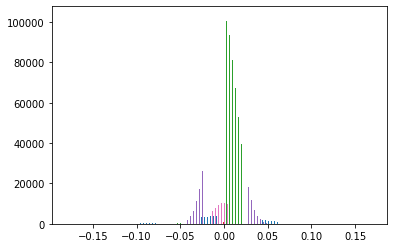

In [ ]:
from math import ceil
batch_size =128
multi_process_workers = 2
if (NUM_GPUS > 1):
    multi_gpu_model.fit_generator(
        DAESequence(dae_data, batch_size=batch_size*NUM_GPUS, verbose=False),
        steps_per_epoch=int(ceil(dae_data.shape[0]/(batch_size*NUM_GPUS))),
        workers=multi_process_workers, use_multiprocessing=True if multi_process_workers>1 else False,
        epochs=500,
        verbose=1,
        callbacks=[
            # keras.callbacks.LambdaCallback(on_epoch_end=lambda x,y: model_dae.save('DAE.keras.model.h5')) # save weights 
        ])
else: # single CPU/GPU
    model_dae.fit_generator(
        DAESequence(dae_data, batch_size=batch_size, verbose=False),
        steps_per_epoch=int(ceil(dae_data.shape[0]/batch_size)),
        epochs=500,
        workers=multi_process_workers, use_multiprocessing=True if multi_process_workers>1 else False,
        verbose=1)
    
model_dae.save('DAE.keras.model.h5') # save weights
plt.hist(model_dae.get_weights(), bins = 100)
plt.show()

# Perturb data

In [ ]:
"""
Discretizers classes, to be used in lime_tabular
"""
import numpy as np
import sklearn
import sklearn.tree
import scipy
from sklearn.utils import check_random_state
from abc import ABCMeta, abstractmethod


class BaseDiscretizer():
    """
    Abstract class - Build a class that inherits from this class to implement
    a custom discretizer.
    Method bins() is to be redefined in the child class, as it is the actual
    custom part of the discretizer.
    """

    __metaclass__ = ABCMeta  # abstract class

    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None,
                 data_stats=None):
        """Initializer
        Args:
            data: numpy 2d array
            categorical_features: list of indices (ints) corresponding to the
                categorical columns. These features will not be discretized.
                Everything else will be considered continuous, and will be
                discretized.
            categorical_names: map from int to list of names, where
                categorical_names[x][y] represents the name of the yth value of
                column x.
            feature_names: list of names (strings) corresponding to the columns
                in the training data.
            data_stats: must have 'means', 'stds', 'mins' and 'maxs', use this
                if you don't want these values to be computed from data
        """
        self.to_discretize = ([x for x in range(data.shape[1])
                               if x not in categorical_features])
        self.data_stats = data_stats
        self.names = {}
        self.lambdas = {}
        self.means = {}
        self.stds = {}
        self.mins = {}
        self.maxs = {}
        self.random_state = check_random_state(random_state)

        # To override when implementing a custom binning
        bins = self.bins(data, labels)
        bins = [np.unique(x) for x in bins]

        # Read the stats from data_stats if exists
        if data_stats:
            self.means = self.data_stats.get("means")
            self.stds = self.data_stats.get("stds")
            self.mins = self.data_stats.get("mins")
            self.maxs = self.data_stats.get("maxs")

        for feature, qts in zip(self.to_discretize, bins):
            n_bins = qts.shape[0]  # Actually number of borders (= #bins-1)
            boundaries = np.min(data[:, feature]), np.max(data[:, feature])
            name = feature_names[feature]

            self.names[feature] = ['%s <= %.2f' % (name, qts[0])]
            for i in range(n_bins - 1):
                self.names[feature].append('%.2f < %s <= %.2f' %
                                           (qts[i], name, qts[i + 1]))
            self.names[feature].append('%s > %.2f' % (name, qts[n_bins - 1]))

            self.lambdas[feature] = lambda x, qts=qts: np.searchsorted(qts, x)
            discretized = self.lambdas[feature](data[:, feature])

            # If data stats are provided no need to compute the below set of details
            if data_stats:
                continue

            self.means[feature] = []
            self.stds[feature] = []
            for x in range(n_bins + 1):
                selection = data[discretized == x, feature]
                mean = 0 if len(selection) == 0 else np.mean(selection)
                self.means[feature].append(mean)
                std = 0 if len(selection) == 0 else np.std(selection)
                std += 0.00000000001
                self.stds[feature].append(std)
            self.mins[feature] = [boundaries[0]] + qts.tolist()
            self.maxs[feature] = qts.tolist() + [boundaries[1]]

    @abstractmethod
    def bins(self, data, labels):
        """
        To be overridden
        Returns for each feature to discretize the boundaries
        that form each bin of the discretizer
        """
        raise NotImplementedError("Must override bins() method")

    def discretize(self, data):
        """Discretizes the data.
        Args:
            data: numpy 2d or 1d array
        Returns:
            numpy array of same dimension, discretized.
        """
        ret = data.copy()
        for feature in self.lambdas:
            if len(data.shape) == 1:
                ret[feature] = int(self.lambdas[feature](ret[feature]))
            else:
                ret[:, feature] = self.lambdas[feature](
                    ret[:, feature]).astype(int)
        return ret

    def get_undiscretize_values(self, feature, values):
        mins = np.array(self.mins[feature])[values]
        maxs = np.array(self.maxs[feature])[values]

        means = np.array(self.means[feature])[values]
        stds = np.array(self.stds[feature])[values]
        minz = (mins - means) / stds
        maxz = (maxs - means) / stds
        min_max_unequal = (minz != maxz)

        ret = minz
        ret[np.where(min_max_unequal)] = scipy.stats.truncnorm.rvs(
            minz[min_max_unequal],
            maxz[min_max_unequal],
            loc=means[min_max_unequal],
            scale=stds[min_max_unequal],
            random_state=self.random_state
        )
        return ret

    def undiscretize(self, data):
        ret = data.copy()
        for feature in self.means:
            if len(data.shape) == 1:
                ret[feature] = self.get_undiscretize_values(
                    feature, ret[feature].astype(int).reshape(-1, 1)
                )
            else:
                ret[:, feature] = self.get_undiscretize_values(
                    feature, ret[:, feature].astype(int)
                )
        return ret


class StatsDiscretizer(BaseDiscretizer):
    """
        Class to be used to supply the data stats info when discretize_continuous is true
    """

    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None,
                 data_stats=None):

        BaseDiscretizer.__init__(self, data, categorical_features,
                                 feature_names, labels=labels,
                                 random_state=random_state,
                                 data_stats=data_stats)

    def bins(self, data, labels):
        bins_from_stats = self.data_stats.get("bins")
        bins = []
        if bins_from_stats is not None:
            for feature in self.to_discretize:
                bins_from_stats_feature = bins_from_stats.get(feature)
                if bins_from_stats_feature is not None:
                    qts = np.array(bins_from_stats_feature)
                    bins.append(qts)
        return bins


class QuartileDiscretizer(BaseDiscretizer):
    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None):

        BaseDiscretizer.__init__(self, data, categorical_features,
                                 feature_names, labels=labels,
                                 random_state=random_state)

    def bins(self, data, labels):
        bins = []
        for feature in self.to_discretize:
            qts = np.array(np.percentile(data[:, feature], [25, 50, 75]))
            bins.append(qts)
        return bins


class DecileDiscretizer(BaseDiscretizer):
    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None):
        BaseDiscretizer.__init__(self, data, categorical_features,
                                 feature_names, labels=labels,
                                 random_state=random_state)

    def bins(self, data, labels):
        bins = []
        for feature in self.to_discretize:
            qts = np.array(np.percentile(data[:, feature],
                                         [10, 20, 30, 40, 50, 60, 70, 80, 90]))
            bins.append(qts)
        return bins


class EntropyDiscretizer(BaseDiscretizer):
    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None):
        if(labels is None):
            raise ValueError('Labels must be not None when using \
                             EntropyDiscretizer')
        BaseDiscretizer.__init__(self, data, categorical_features,
                                 feature_names, labels=labels,
                                 random_state=random_state)

    def bins(self, data, labels):
        bins = []
        for feature in self.to_discretize:
            # Entropy splitting / at most 8 bins so max_depth=3
            dt = sklearn.tree.DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=3,
                                                     random_state=self.random_state)
            x = np.reshape(data[:, feature], (-1, 1))
            dt.fit(x, labels)
            qts = dt.tree_.threshold[np.where(dt.tree_.children_left > -1)]

            if qts.shape[0] == 0:
                qts = np.array([np.median(data[:, feature])])
            else:
                qts = np.sort(qts)

            bins.append(qts)

        return bins

In [ ]:
def data_inverse(training_data,training_labels,sample_around_instance,num_samples,random_seed,data_row=None,
                 kernel_width=None,kernel=None,categorical_features=None,
                 categorical_names=None,feature_values=None,feature_names=None,feature_frequencies=None
                       ): 
  discretize_continuous=True
  training_data_stats=False
  random_state = check_random_state(random_seed)
  categorical_names = categorical_names or {}

  if categorical_features is None:
      categorical_features = []
  if feature_names is None:
      feature_names = [str(i) for i in range(training_data.shape[1])]

  categorical_features = list(categorical_features)
  feature_names = list(feature_names)
  # if discretize_continuous and not sp.sparse.issparse(training_data):
  #   discretizer = QuartileDiscretizer(
  #               training_data, categorical_features,
  #               feature_names, labels=training_labels,
  #               random_state=random_state)
  #   categorical_features = list(range(training_data.shape[1]))

  #           # Get the discretized_training_data when the stats are not provided
  #   discretized_training_data = discretizer.discretize(training_data)


  if kernel_width is None:
      kernel_width = np.sqrt(training_data.shape[1]) * .75
  kernel_width = float(kernel_width)

  if kernel is None:
      def kernel(d, kernel_width):
          return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

  kernel_fn = partial(kernel, kernel_width=kernel_width)

  # Though set has no role to play if training data stats are provided
  scaler = sklearn.preprocessing.StandardScaler(with_mean=True)
  scaler.fit(training_data)
  feature_values = {}
  feature_frequencies = {}
  
  for feature in categorical_features:
      column = training_data.iloc[:, feature]

      feature_count = collections.Counter(column)
      values, frequencies = map(list, zip(*(sorted(feature_count.items()))))

      feature_values[feature] = values
      feature_frequencies[feature] = (np.array(frequencies) /
                                            float(sum(frequencies)))
      scaler.mean_[feature] = 0
      scaler.scale_[feature] = 1
  """Generates a neighborhood around a prediction.
  For numerical features, perturb them by sampling from a Normal(0,1) and
  doing the inverse operation of mean-centering and scaling, according to
  the means and stds in the training data. For categorical features,
  perturb by sampling according to the training distribution, and making
  a binary feature that is 1 when the value is the same as the instance
  being explained.
  Args:
      data_row: 1d numpy array, corresponding to a row
      num_samples: size of the neighborhood to learn the linear model
      sampling_method: 'gaussian' or 'lhs'
  Returns:
      A tuple (data, inverse), where:
          data: dense num_samples * K matrix, where categorical features
          are encoded with either 0 (not equal to the corresponding value
          in data_row) or 1. The first row is the original instance.
          inverse: same as data, except the categorical features are not
          binary, but categorical (as the original data)
  """
  if sample_around_instance:
    is_sparse = sp.sparse.issparse(data_row)
    if is_sparse:
        num_cols = data_row.shape[1]
        data = sp.sparse.csr_matrix((num_samples, num_cols), dtype=data_row.dtype)
    else:
        num_cols = data_row.shape[0]
        data = np.zeros((num_samples, num_cols))
  else:
    is_sparse=False
    num_cols= train.shape[1]
    data = np.zeros((num_samples, num_cols))

  if categorical_features is None:
    categorical_features = range(num_cols)
  instance_sample = data_row
  scale = scaler.scale_
  mean = scaler.mean_
  if is_sparse:
      # Perturb only the non-zero values
      non_zero_indexes = data_row.nonzero()[1]
      num_cols = len(non_zero_indexes)
      instance_sample = data_row[:, non_zero_indexes]
      scale = scale[non_zero_indexes]
      mean = mean[non_zero_indexes]
      
  data = random_state.normal(0, 1, num_samples * num_cols
                                  ).reshape(num_samples, num_cols)
  data = np.array(data)

  if sample_around_instance:
      data = data * scale + instance_sample
  else:
      data = data * scale + mean
  inverse = data.copy()
  for column in categorical_features:
      values =feature_values[column]
      freqs = feature_frequencies[column]
      inverse_column = random_state.choice(values, size=num_samples,
                                                replace=True, p=freqs)
      # binary_column = (inverse_column == first_row[column]).astype(int)
      binary_column=inverse_column
      # binary_column[0] = 1
      # inverse_column[0] = data[0, column]
      data[:, column] = binary_column
      inverse[:, column] = inverse_column
  return data, inverse


In [ ]:
def get_perturbed_points(dataset_name , seed):
  if dataset_name is 'liver':
    categorical_features=[0]
    feature_values=[data[data.columns[0]].unique()]
    new_data_points,inverse=data_inverse(train,labels_train,False,10000,random_seed=seed,feature_values=feature_values,categorical_features=categorical_features)
    df_new_points=pd.DataFrame(new_data_points , columns=train.columns)
    normalized_new=normalize_data(df_new_points,True)
    return normalized_new,df_new_points,new_data_points
  elif dataset_name is 'breast_cancer':
    new_data_points,inverse=data_inverse(train,labels_train,False,10000,random_seed=seed)
    df_new_points=pd.DataFrame(new_data_points)
    normalized_new=normalize_data(df_new_points,False)
    return normalized_new,df_new_points,new_data_points
  elif dataset_name is 'hepatisis':
    categorical_features=[0,1,2,3,4,5,6,7,8,9,10,11,12]
    feature_values=[data[data.columns[i]].unique() for i in range(13)]
    new_data_points,inverse=data_inverse(train,labels_train,False,10000,random_seed=seed,feature_values=feature_values,categorical_features=categorical_features)
    df_new_points=pd.DataFrame(new_data_points , columns=train.columns)
    normalized_new=normalize_data(df_new_points,True)
    return normalized_new,df_new_points,new_data_points
  elif dataset_name is 'adults':
    categorical_features=range(6,105)
    feature_values=[data[data.columns[i]].unique() for i in range(6,105)]
    new_data_points,inverse=data_inverse(train,labels_train,False,5000,random_seed=seed,feature_values=feature_values,categorical_features=categorical_features)
    df_new_points=pd.DataFrame(new_data_points , columns=train.columns)
    normalized_new=normalize_data(df_new_points,True)
    return normalized_new,df_new_points,new_data_points
  else:
    print("dataset_name is not correct")

In [ ]:
normalized_new,df_new_points,new_data_points=get_perturbed_points('breast_cancer',5)

In [ ]:
normalized_new,df_new_points,new_data_points=get_perturbed_points('liver',5)

In [ ]:
normalized_new,df_new_points,new_data_points=get_perturbed_points('hepatisis',5)

In [ ]:
normalized_new,df_new_points,new_data_points=get_perturbed_points('adults',5)

In [ ]:
normalized_new

In [ ]:
def get_AE_output(input_data):
  new_df=pd.DataFrame()
  for i in ['1','2','3']:
    columns_names = ['Hidden_'+str(i)+'_'+str(l) for l in range(0, len_input_columns*10)]
    for l in columns_names:
       new_df[l] = 0 # create columns (maybe it's not optimized)
    intermediate_layer_model = Model(inputs=model_dae.input, outputs=model_dae.get_layer('Hidden' + i).output)
    new_df[columns_names] = intermediate_layer_model.predict(input_data)
  return new_df

# Train black-box model (here a feed forward model)

In [ ]:
def main_model_fit(train1, labels_train1,val,labels_val, K,num_units1,num_units2=None):
  early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=1, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False)
  if num_units2 is not None: 
     model=tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(units=num_units1),
                                    tf.keras.layers.Dense(units=num_units2)
                                   ,tf.keras.layers.Dense(1,activation='sigmoid')]) 
  else:
     model=tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(units=num_units1)
                                   ,tf.keras.layers.Dense(1,activation='sigmoid')]) 
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
  history= model.fit(train1, labels_train1,validation_data=(val,labels_val) ,epochs=100,verbose=0  ,callbacks=[early_stopping] )
  return history,model

In [ ]:
def main_model_fit_final(train1, labels_train1,K,num_units1,num_units2=None):
  if num_units2 is not None: 
     model=tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(units=num_units1),
                                    tf.keras.layers.Dense(units=num_units2)
                                   ,tf.keras.layers.Dense(1,activation='sigmoid')]) 
  else:
     model=tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(units=num_units1)
                                   ,tf.keras.layers.Dense(1,activation='sigmoid')]) 
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
  history= model.fit(train1, labels_train1,epochs=100,verbose=1  )
  return history,model

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
tf.random.set_seed(0)
history,model=main_model_fit_final(normalized_train,labels_train,20,5)
predict_labels=model.predict(normalized_test)
labels=[0 if x<=0.5 else 1 for x in predict_labels]
acc_test=metrics.accuracy_score(labels_test,labels)
print(acc_test)

In [ ]:
num_units=[5,10,15,20,25,30,35]
tf.random.set_seed(0)
kf = KFold(n_splits=10)
average_accuracy=0
df_labels=pd.DataFrame(labels)
# df_data=pd.DataFrame(data)
for train_index, test_index in kf.split(normalized_data):
  X_train, X_test = normalized_data.iloc[train_index], normalized_data.iloc[test_index]
  y_train, y_test = df_labels.iloc[train_index], df_labels.iloc[test_index]
  (train1,val,labels_train1,labels_val) = model_selection.train_test_split(X_train, y_train, train_size=0.90)
  min_loss=1000
  for unit1 in num_units:
    print(unit1)
    for unit2 in num_units:
      history,model=main_model_fit(train1,labels_train1,val,labels_val,unit1,unit2)
      loss=history.history['val_loss'][len(history.history['val_loss'])-1]
      if loss<min_loss:
        min_loss=loss
        best_model=model
        best_accuracy=history.history['val_accuracy'][len(history.history['val_accuracy'])-1]
        best_num_unit1=unit1
        best_num_unit2=unit2
    # print(history.history['val_accuracy'])
  print(best_accuracy)
  print(best_num_unit1)
  print(best_num_unit2)
  predict_labels=best_model.predict(X_test)
  labels=[0 if x<=0.5 else 1 for x in predict_labels]
  acc_test=metrics.accuracy_score(y_test,labels)
  average_accuracy+=acc_test
  print(acc_test)
average_accuracy=average_accuracy/10.0
print(average_accuracy)

In [ ]:
predict_labels=model.predict(normalized_test)
labels=[0 if x<=0.5 else 1 for x in predict_labels]
metrics.accuracy_score(labels_test,labels)

0.8533114955471389

In [ ]:
# model=best_model

# ALIME and tree_ALIME

In [ ]:
def ALIME(x, n , model ,new_data_points,normalized_new):
  embedded_new_data_points=get_AE_output(normalized_new)
  embedded_x=get_AE_output(x)
  emb_new_array=np.array(embedded_new_data_points)
  emb_x_array=np.array(embedded_x)
  d=np.linalg.norm(emb_new_array-emb_x_array , axis=1)
  dmin=heapq.nsmallest(n, d)[-1]
  local_dataset_norm=[]
  local_dataset=[]
  weights=np.zeros(n)
  count=0
  for i in range(len(d)):
     if d[i]<=dmin:
       local_dataset.append(new_data_points[i])
       local_dataset_norm.append(normalized_new.iloc[i])
       weights[count]=np.exp(-d[i])
       count+=1
  
  df_local_dataset=pd.DataFrame(local_dataset_norm,columns=dae_data.columns)
  predict_labels=model.predict(df_local_dataset)
  labels=[0 if x<=0.5 else 1 for x in predict_labels]
  sum=np.sum(labels)
  l_model=None
  predict=None
  if sum==0 or sum==len(labels):
    predict=sum/len(labels)
  else:
    l_model=sklearn.linear_model.LogisticRegression(max_iter=150,solver='liblinear', random_state=0)
    l_model.fit(local_dataset_norm,labels,sample_weight=weights )
  return l_model,predict


In [ ]:
def ALIME_linear_and_tree(x, n , model ,new_data_points,normalized_new):
  embedded_new_data_points=get_AE_output(normalized_new)
  embedded_x=get_AE_output(x)
  emb_new_array=np.array(embedded_new_data_points)
  emb_x_array=np.array(embedded_x)
  d=np.linalg.norm(emb_new_array-emb_x_array , axis=1)
  dmin=heapq.nsmallest(n, d)[-1]
  local_dataset_norm=[]
  local_dataset=[]
  weights=np.zeros(n)
  count=0
  for i in range(len(d)):
     if d[i]<=dmin:
       local_dataset.append(new_data_points[i])
       local_dataset_norm.append(normalized_new.iloc[i])
       weights[count]=np.exp(-d[i])
       count+=1
  
  df_local_dataset=pd.DataFrame(local_dataset_norm,columns=dae_data.columns)
  predict_labels=model.predict(df_local_dataset)
  labels=[0 if x<=0.5 else 1 for x in predict_labels]
  sum=np.sum(labels)
  l_model=None
  tree_model=None
  predict=None
  if sum==0 or sum==len(labels):
    predict=sum/len(labels)
  else:
    l_model=sklearn.linear_model.LogisticRegression(max_iter=150,solver='liblinear', random_state=0)
    l_model.fit(local_dataset_norm,labels,sample_weight=weights )

    tree_model=sklearn.tree.DecisionTreeClassifier(random_state=0,max_depth=5)
    tree_model.fit(local_dataset,labels,sample_weight=weights)

  return l_model,tree_model,predict

In [ ]:
def test_on_a_data_ALIME(num_features, num_data):
  dae_test = normalized_test
  dat_norm=dae_test.iloc[num_data]
  series_obj = pd.Series(dat_norm)
  arr = series_obj.values
  x = arr.reshape((1, num_features))
  l_model,tree_model,predict= ALIME_linear_and_tree(x,300, model ,new_data_points,normalized_new)
  return x,l_model,tree_model


In [ ]:
x,l_model,tree_model=test_on_a_data_ALIME(train.shape[1],10)

In [ ]:
l_model.coef_

In [ ]:
import graphviz
import os
def visualize_ALIME(dataset_name):
  i=0
  count=[]
  cols=['num']
  cols+=list(df_new_points.columns)
  df_data=pd.DataFrame(columns=cols)
  while len(count)<20:
    num_test=np.random.randint(0,len(normalized_test))
    while num_test in count:
      num_test=np.random.randint(0,len(normalized_test))
    print(num_test)
    print(test.iloc[num_test])
    print('-----------')
    dat=[num_test]
    dat+=list(test.iloc[num_test])
    df_data.loc[i]=dat
    i+=1
    print(df_data)
    count.append(num_test)
    x,l_model,tree_model=test_on_a_data_ALIME(train.shape[1],num_test)
    fig = plt.figure(figsize =(10,10))
    coefs=[]
    feature_names=[]
    select_df = pd.DataFrame(columns=['coefs','feature_name'])
    if l_model !=None and tree_model!=None:
      coefs_row= l_model.coef_.reshape(-1)
      df = pd.DataFrame({'coefs':coefs_row,
                        'feature_name':train.columns})
      df = df.sort_values(by='coefs')
      select_df = df.head(5).append(df.tail(5))
    if l_model !=None :
      bar=plt.barh(select_df.feature_name, select_df.coefs)
      plt.xlabel('weights')
      plt.ylabel('features')
      fig.savefig('{}/linear_model/{}.png'.format(dataset_name,num_test))

    if tree_model!=None:
      print(class_names)
      dot_data=sklearn.tree.export_graphviz(tree_model, out_file=None, 
                                    feature_names=train.columns,  
                                    class_names=class_names,
                                    filled=True,impurity=False)
      graph = graphviz.Source(dot_data, format="png") 
      graph.render('{}/tree_model/{}'.format(dataset_name,num_test))
  df_data.to_csv('adults_test.csv')
  return df_data

In [ ]:
visualize_ALIME('adults')

In [ ]:
!zip -r /content/adults.zip /content/adults

In [ ]:
visualize_ALIME('breastCancer')

In [ ]:
!zip -r /content/breast_cancer.zip /content/breastCancer

In [ ]:
visualize_ALIME('hepatisis')

In [ ]:
def ALIME_decision_Tree(x , n ,  model,new_data_points,normalized_new):
  embedded_new_data_points=get_AE_output(normalized_new)
  embedded_x=get_AE_output(x)
  emb_new_array=np.array(embedded_new_data_points)
  emb_x_array=np.array(embedded_x)
  d=np.linalg.norm(emb_new_array-emb_x_array , axis=1)
  dmin=heapq.nsmallest(n, d)[-1]
  local_dataset_norm=[]
  local_dataset=[]
  weights=np.zeros(n)
  count=0
  for i in range(len(d)):
     if d[i]<=dmin:
       local_dataset.append(new_data_points[i])
       local_dataset_norm.append(normalized_new.iloc[i])
       weights[count]=np.exp(-d[i])
       count+=1
  
  df_local_dataset=pd.DataFrame(local_dataset_norm,columns=dae_data.columns)
  predict_labels=model.predict(df_local_dataset)
  labels=[0 if x<=0.5 else 1 for x in predict_labels]
  tree_model=sklearn.tree.DecisionTreeClassifier(random_state=0)
  tree_model.fit(local_dataset,labels,sample_weight=weights)
  return tree_model

In [ ]:
def test_on_a_data_ALIME_decision_Tree(num_features, num_data):
  dae_test = normalized_test
  dat_norm=dae_test.iloc[num_data]
  series_obj = pd.Series(dat_norm)
  arr = series_obj.values
  x = arr.reshape((1, num_features))
  tree_model=ALIME_decision_Tree(x,100,model,new_data_points,normalized_new)
  return x,tree_model


In [ ]:
x,tree_model=test_on_a_data_ALIME_decision_Tree(train.shape[1],10)

In [ ]:
tree_model.feature_importances_

In [ ]:
data.feature_names

In [ ]:
text_representation = tree.export_text(tree_model , feature_names=list(data.feature_names))
print(text_representation)

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_model, 
                   feature_names=data.feature_names,  
                   class_names=data.target_names,
                   filled=True ,impurity=False)


# Evaluate Fidelity and Stability

In [ ]:
def evaluate_fidelity(model,K,dataset_name):
  dae_test = normalized_test.sample(n=1000)
  labels= model.predict(dae_test)
  truth_labels=[0 if x<=0.5 else 1 for x in labels]
  f=open("drive/MyDrive/accuracies_{}.txt".format(dataset_name),'w')
  truth_labels_all=[]
  for num_data in range(100,1500,100):
    predict_labels1=[]
    predict_labels2=[]
    print(num_data)
    for i in range(len(dae_test)):
      dat= dae_test.iloc[i]
      series_obj = pd.Series(dat)
      arr = series_obj.values
      x = arr.reshape((1, K))
      l_model,tree_model,predict=ALIME_linear_and_tree(x,num_data,model,new_data_points,normalized_new)
      if predict==None:
        predict_labels1.append(l_model.predict(x)[0])
        predict_labels2.append(tree_model.predict(x)[0])
      else:
        predict_labels1.append(predict)
        predict_labels2.append(predict)
      truth_labels_all.append(truth_labels[i])
      if i%5==0:
        print(i)
    f.write(str(num_data))
    f.write("\n")
    accuracy1=metrics.accuracy_score(truth_labels_all,predict_labels1)
    f.write(str(accuracy1))
    f.write("\n")

    accuracy2=metrics.accuracy_score(truth_labels_all,predict_labels2)
    f.write(str(accuracy2))
  
    f.write("\n")
    f.write('----------')
    f.write("\n")
    f.flush()

    print(accuracy1)
    print(accuracy2)

  f.close()

In [ ]:
evaluate_fidelity(model,train.shape[1],'adults')

In [ ]:
import matplotlib.pyplot as plt
def plot_fidelity(dataset_name):
  f=open("accuracies_{}.txt".format(dataset_name),'r')
  lines=f.readlines()
  nums=[]
  accs_alime=[]
  accs_tree=[]
  for i in range(0,len(lines),4):
    num_data=lines[i]
    acc_alime=lines[i+1]
    acc_tree=lines[i+2]
    nums.append(int(num_data))
    accs_alime.append(float(acc_alime))
    accs_tree.append(float(acc_tree))
  
  plt.title(dataset_name)
  plt.xlabel("num_data")
  plt.ylabel("accuracy")
  plt.plot(nums,accs_alime, label='linear')
  plt.plot(nums,accs_tree , label='decision_tree')
  plt.legend()
  plt.show()

In [ ]:
plot_fidelity('breast_cancer')

In [ ]:
plot_fidelity('hepatisis')

In [ ]:
def get_pos_And_neg_ind(array):
  pos=[]
  neg=[]
  count=0
  shape=array.shape
  for i in range(shape[0]):
    for j in range(shape[1]):
      if array[i][j]>=0.01:
        pos.append(count)
      elif array[i][j]<=-0.01:
        neg.append(count)
      count+=1
  return pos,neg

In [ ]:
def evaluate_stability(model,K,dataset_name):
  dae_test = normalized_test
  dat_norm=dae_test.iloc[np.random.randint(0,len(dae_test))]
  series_obj = pd.Series(dat_norm)
  arr = series_obj.values
  x_norm = arr.reshape((1, K))
  f= open('drive/MyDrive/stability_{}.txt'.format(dataset_name),'w')
  for num_data in range(100,1600,100):
    print(num_data)
    f.write(str(num_data))
    f.write('\n')
    tree_features=[]
    l_features_pos=[]
    l_features_neg=[]
    for seed in range(20):
      if seed%5==0:
        print(seed)
      normalized_new,df_new_points,new_data_points=get_perturbed_points(dataset_name,seed)
      l_model,tree_model,predict=ALIME_linear_and_tree(x_norm,num_data,model,new_data_points,normalized_new)
      pos,neg=get_pos_And_neg_ind(l_model.coef_)
      l_features_pos.append(pos)
      l_features_neg.append(neg)
      important_features_tree=np.nonzero(tree_model.feature_importances_)
      tree_features.append(important_features_tree)
  #stability of ALIME linear
    res_pos=0
    count_pos=0
    sum_len_pos=0
    for i in range(len(l_features_pos)):
      sum_len_pos+=len(l_features_pos[i])
      for j in range(len(l_features_pos)):
        if i != j:
          set1=set(l_features_pos[i])
          set2=set(l_features_pos[j])
          union1=set1.union(set2)
          intersection1=set1.intersection(set2)
          if len(union1)>0:
            res_pos+=len(intersection1)/len(union1)
            count_pos+=1
    res_neg=0
    count_neg=0
    sum_len_neg=0
    for i in range(len(l_features_neg)):
      sum_len_neg+=len(l_features_neg[i])
      for j in range(len(l_features_neg)):
        if i != j:
          set1=set(l_features_neg[i])
          set2=set(l_features_neg[j])
          union1=set1.union(set2)
          intersection1=set1.intersection(set2)
          if len(union1)>0:
            res_neg+=len(intersection1)/len(union1)
            count_neg+=1
    ave_len_all=(sum_len_neg+sum_len_pos) /(len(l_features_pos)+len(l_features_neg))
    stab_pos=0
    stab_neg=0
    if count_pos>0:
      stab_pos=res_pos/count_pos
    if count_neg>0:
      stab_neg=res_neg/count_neg
    
    stab_all=(stab_pos+stab_neg)/2.0
    f.write(str(ave_len_all))
    f.write('\n')
    f.write(str(stab_all))
    f.write('\n')
    print('average_length ={}'.format(ave_len_all))
    print('ALIME linear stability = {}'.format(stab_all))

    #stability of ALIME tree
    res=0
    count=0
    sum_len=0
    for i in range(len(tree_features)):
      sum_len+=len(tree_features[i][0])
      for j in range(len(tree_features)):
        if i is not j:
          set1=set(tree_features[i][0])
          set2=set(tree_features[j][0])
          union1=set1.union(set2)
          intersection1=set1.intersection(set2)
          if len(union1)>0:
             res+=len(intersection1)/len(union1)
             count+=1
    f.write(str(sum_len/len(tree_features)))
    f.write('\n')
    f.write(str(res/count))
    f.write('\n')
    f.write('--------------')
    f.write('\n')
    f.flush()
    print('average_length ={}'.format(sum_len/len(tree_features)))
    print('ALIME tree stability = {}'.format(res/count))
  f.close()

In [ ]:
evaluate_stability(model,train.shape[1],'adults')